In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, PredefinedSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
# train/test set creation

df = pd.read_json("../data/postdatalinesvectors.json",orient='records',lines=True)
X = df[[str(i) for i in range(38)]]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=101)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

              precision    recall  f1-score   support

  depression       0.76      0.69      0.72        90
      normal       0.65      0.72      0.68        71

    accuracy                           0.70       161
   macro avg       0.70      0.70      0.70       161
weighted avg       0.71      0.70      0.70       161



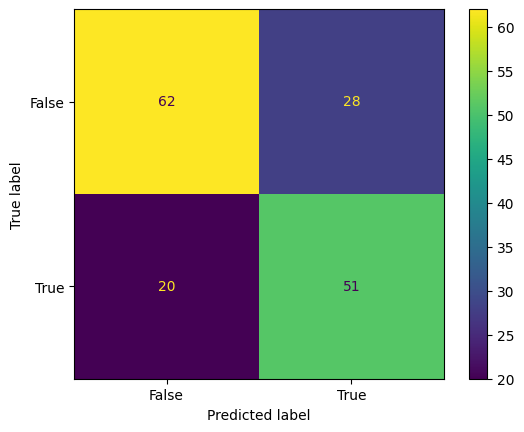

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

model = SVC(random_state=0, probability=True, class_weight='balanced', C=10, gamma=1000, kernel='rbf')
model.fit(X_train,y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))
# print(roc_auc_score(y_test,model_pred))

# my_list = (list(zip(model_pred,list(y_test))))

# truepos = 0
# falseneg = 0
# trueneg = 0
# falsepos = 0
# total = 0

# for i in range(len(my_list)):
#     if my_list[i][0] == 'depression':
#         if my_list[i][0] == my_list[i][1]:
#             truepos += 1
#         else:
#             falseneg += 1
#     if my_list[i][0] == 'normal':
#         if my_list[i][0] == my_list[i][1]:
#             trueneg += 1
#         else:
#             falsepos += 1
#     total += 1

# print(f'truepositives: {truepos}    falsepostives: {falsepos}\n falsenegatvives: {falseneg}     truenegatives: {trueneg}\n total: {total}')

confusionmatrix = confusion_matrix(y_test,model_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusionmatrix, display_labels = [False, True]) 
cm_display.plot()
plt.show()  
